In [2]:
import pandas as pd

#created in the EDA notebook
train_df = pd.read_csv('CheXpert-v1.0-small/train_ours.csv')
valid_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')
test_df = pd.read_csv('CheXpert-v1.0-small/test_ours.csv')

train_df.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,CheXpert-v1.0-small/train/patient24603/study1/...,Male,71,Frontal,AP,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient24603
1,CheXpert-v1.0-small/train/patient19482/study8/...,Male,77,Frontal,PA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,patient19482
2,CheXpert-v1.0-small/train/patient03111/study1/...,Male,52,Frontal,PA,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,1.0,NaN,NaN,NaN,patient03111
3,CheXpert-v1.0-small/train/patient05085/study1/...,Female,33,Frontal,AP,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,patient05085
4,CheXpert-v1.0-small/train/patient14133/study1/...,Male,66,Frontal,PA,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,patient14133


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# create labels, which will be a dictionary with image path: list of labels

disease_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
if 0:
    train_df = train_df.sample(frac=0.01, random_state=123)
#replace -1 with 2 for the uncertain class
train_df[disease_cols] = train_df[disease_cols].replace([-1.0],2.0)
train_labels = train_df[disease_cols].values
train_paths = train_df.Path.values
train_ages = train_df.Age.values
train_genders = train_df.Sex.values

valid_df[disease_cols] = valid_df[disease_cols].replace([-1.0],2.0)
valid_labels = valid_df[disease_cols].values
valid_paths = valid_df.Path.values
valid_ages = valid_df.Age.values
valid_genders = valid_df.Sex.values

test_df[disease_cols] = test_df[disease_cols].replace([-1.0],2.0)
test_labels = test_df[disease_cols].values
test_paths = test_df.Path.values
test_ages = test_df.Age.values
test_genders = test_df.Sex.values

In [28]:
train_df_short = train_df[['Path','Sex','Age','Frontal/Lateral','AP/PA','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion','patient_id']]
valid_df_short = valid_df[['Path','Sex','Age','Frontal/Lateral','AP/PA','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
test_df_short = test_df[['Path','Sex','Age','Frontal/Lateral','AP/PA','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion','patient_id']]


train_df.head()

In [27]:
valid_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

{'Cardiomegaly': 26405, 'Edema': 51017, 'Consolidation': 14452, 'Atelectasis': 32596, 'Pleural Effusion': 84160}


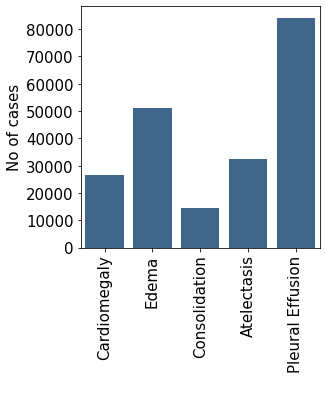

In [73]:
import seaborn as sns
disease_cols = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
disease_count_train = {}
disease_count_val = {}
disease_count_test = {}

for col in disease_cols:
    disease_count_train[col]=train_df_short[col].value_counts()[1] #gets count of those with 1
    disease_count_val[col]=valid_df_short[col].value_counts()[1] #gets count of those with 1
    disease_count_test[col]=train_df_short[col].value_counts()[1] #gets count of those with 1
print(disease_count_train)


disease_count_train_df = pd.DataFrame(list(disease_count_train.items()),columns = [' ','No of cases']) 
disease_count_val_df = pd.DataFrame(list(disease_count_val.items()),columns = [' ','No of cases']) 
disease_count_test_df = pd.DataFrame(list(disease_count_test.items()),columns = [' ','No of cases']) 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = 0.35
ind = np.arange(5)
plt.figure(figsize=(5,6))
ax=sns.barplot(x=' ', y='No of cases', data=disease_count_train_df,color=(0.2, 0.4, 0.6, 0.6))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 22})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.tight_layout()
plt.savefig('disease_count_train.png')


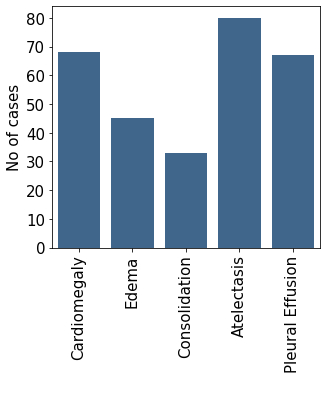

In [74]:
plt.figure(figsize=(5,6))
ax=sns.barplot(x=' ', y='No of cases', data=disease_count_val_df,color=(0.2, 0.4, 0.6, 0.6))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 22})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    plt.tight_layout()
plt.savefig('disease_count_val.png')


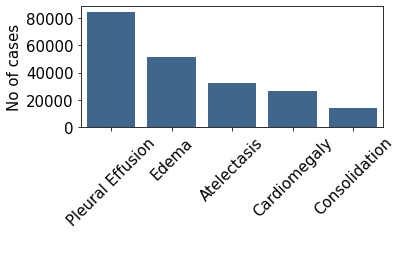

In [75]:
ax=sns.barplot(x=' ', y='No of cases', data=disease_count_test_df.sort_values(by='No of cases', ascending=False),color=(0.2, 0.4, 0.6, 0.6))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.rcParams.update({'font.size': 22})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.tight_layout()
plt.savefig('disease_count_test.png')